In [1]:
import os
os.chdir('../..')

In [2]:
import logging
import sys

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Avoid duplicate handlers
if not logger.handlers:
    handler = logging.StreamHandler(sys.stdout)  # stdout works better than stderr in Jupyter
    handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
    logger.addHandler(handler)

In [3]:
import numpy as np
from sklearn.model_selection import KFold
import time
from sklearn.metrics import root_mean_squared_error, mean_squared_log_error
import lightgbm as lgb


def rmsle(y_true, y_pred):
    """Calculates Root Mean Squared Logarithmic Error safely."""
    y_pred_clipped = np.maximum(y_pred, 0)
    y_true_clipped = np.maximum(y_true, 0)
    return np.sqrt(mean_squared_log_error(y_true_clipped + 1, y_pred_clipped + 1))

class BaseModelWrapper:
    def __init__(self, model_cls, model_params, name):
        self.model_cls = model_cls
        self.model_params = model_params
        self.name = name
        self.models = []
        self.oof_preds = None

    def fit(self, X, y, folds=5):
        start_time = time.time()
        logger.info(f"Starting training of {self.name} model with {folds} folds")
        
        self.oof_preds = np.zeros(len(X))
        self.models = []
        kf = KFold(n_splits=folds, shuffle=True, random_state=42)

        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            fold_start = time.time()
            logger.info(f"Training {self.name} - Fold {fold}/{folds}")
            
            X_train = X.iloc[train_idx]
            X_val   = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            model = self.model_cls(**self.model_params)
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmsle', 
                      callbacks=[
                        lgb.early_stopping(stopping_rounds=100),
                        lgb.log_evaluation(period=100)
                    ])
            self.oof_preds[val_idx] = model.predict(X_val)

            # Calculate oof fold validation using RMSE
            fold_rmse = rmsle(y_val, self.oof_preds[val_idx])
            logger.info(f"Fold {fold} RMSLE: {fold_rmse:.4f}")

            self.models.append(model)
            
            fold_time = time.time() - fold_start
            logger.info(f"Completed {self.name} - Fold {fold}/{folds} in {fold_time:.2f} seconds")

        total_time = time.time() - start_time
        
        # Calculate oof validation using RMSE
        rmse = rmsle(y, self.oof_preds)
        logger.info(f"Out-of-fold RMSLE: {rmse:.4f}")

        logger.info(f"Completed training of {self.name} model in {total_time:.2f} seconds")

    def predict(self, X):
        preds = [model.predict(X) for model in self.models]
        return np.mean(np.column_stack(preds), axis=1)

    def retrain_full(self, X, y):
        start_time = time.time()
        logger.info(f"Starting full retraining of {self.name} model")
        
        model = self.model_cls(**self.model_params)
        model.fit(X, y)
        self.models = [model]
        
        total_time = time.time() - start_time
        logger.info(f"Completed full retraining of {self.name} model in {total_time:.2f} seconds")

# Data preprocessing

In [16]:
import pandas as pd

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Transform Sex to 0 and 1
df_train['Sex'] = df_train['Sex'].map({'male': 0, 'female': 1})
df_test['Sex'] = df_test['Sex'].map({'male': 0, 'female': 1})

# Transform target (Calories) with log1p
df_train['Calories'] = np.log1p(df_train['Calories'])

# Create column interactions between all numerical columns
numeric_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

# Create interaction features
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        col1, col2 = numeric_cols[i], numeric_cols[j]
        interaction_name = f'{col1}_{col2}_interaction'
        df_train[interaction_name] = df_train[col1] * df_train[col2]
        df_test[interaction_name] = df_test[col1] * df_test[col2]


# Prepare features and target
X_train = df_train.drop(['Calories', 'id'], axis=1)
y_train = df_train['Calories']

In [ ]:
import lightgbm as lgb

lgbm_model = BaseModelWrapper(
    lgb.LGBMRegressor,
    {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': 1024,
        'max_bin': 1024,
        'learning_rate': 0.02,
        'subsample': 0.8,
        'n_estimators': 100,
        'verbose': 1
    },
    name='lgbm'
)

lgbm_model.fit(X_train, y_train, folds=3)

2025-05-09 19:23:45,660 - INFO - Starting training of lgbm model with 3 folds
2025-05-09 19:23:45,703 - INFO - Training lgbm - Fold 1/3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14665
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 22
[LightGBM] [Info] Start training from score 4.141365
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.142667
[200]	valid_0's rmse: 0.0635918
[300]	valid_0's rmse: 0.0610013
[400]	valid_0's rmse: 0.0610217
Early stopping, best iteration is:
[334]	valid_0's rmse: 0.0609697
2025-05-09 19:25:56,723 - INFO - Fold 1 RMSE: 0.0610
2025-05-09 19:25:56,724 - INFO - Completed lgbm - Fold 1/3 in 131.02 seconds
2025-05-09 19:25:56,744 - INFO - Training lgbm - Fold 2/3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of te

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Encode Sex
df_train['Sex'] = df_train['Sex'].map({'male': 0, 'female': 1})
df_test['Sex'] = df_test['Sex'].map({'male': 0, 'female': 1})

# Log1p transform the target
# df_train['Calories'] = np.log1p(df_train['Calories'])

# Base features
df_train['BMI'] = df_train['Weight'] / ((df_train['Height']/100) ** 2)
df_test['BMI'] = df_test['Weight'] / ((df_test['Height']/100) ** 2)

df_train['Exercise_Intensity'] = df_train['Heart_Rate'] / df_train['Age']
df_test['Exercise_Intensity'] = df_test['Heart_Rate'] / df_test['Age']

df_train['Duration_per_BMI'] = df_train['Duration'] / df_train['BMI']
df_test['Duration_per_BMI'] = df_test['Duration'] / df_test['BMI']

df_train['BMR'] = 10 * df_train['Weight'] + 6.25 * (df_train['Height']/100) - 5 * df_train['Age'] + 5
df_test['BMR'] = 10 * df_test['Weight'] + 6.25 * (df_test['Height']/100) - 5 * df_test['Age'] + 5

df_train['Body_Fat_Percentage'] = (1.2 * df_train['BMI']) + (0.23 * df_train['Age']) - (10.8 * df_train['Sex']) - 5.4
df_test['Body_Fat_Percentage'] = (1.2 * df_test['BMI']) + (0.23 * df_test['Age']) - (10.8 * df_test['Sex']) - 5.4

df_train['Resting_Heart_Rate'] = 0.7 * df_train['Heart_Rate'] + (0.3 * df_train['Age']) - 5.4
df_test['Resting_Heart_Rate'] = 0.7 * df_test['Heart_Rate'] + (0.3 * df_test['Age']) - 5.4

# Interactions
df_train['Height_x_Age'] = df_train['Height'] * df_train['Age']
df_test['Height_x_Age'] = df_test['Height'] * df_test['Age']

df_train['Weight_x_Duration'] = df_train['Weight'] * df_train['Duration']
df_test['Weight_x_Duration'] = df_test['Weight'] * df_test['Duration']

df_train['HeartRate_x_Duration'] = df_train['Heart_Rate'] * df_train['Duration']
df_test['HeartRate_x_Duration'] = df_test['Heart_Rate'] * df_test['Duration']

df_train['BMI_x_Duration'] = df_train['BMI'] * df_train['Duration']
df_test['BMI_x_Duration'] = df_test['BMI'] * df_test['Duration']

df_train['ExerciseIntensity_x_Duration'] = df_train['Exercise_Intensity'] * df_train['Duration']
df_test['ExerciseIntensity_x_Duration'] = df_test['Exercise_Intensity'] * df_test['Duration']

df_train['BMR_x_Duration'] = df_train['BMR'] * df_train['Duration']
df_test['BMR_x_Duration'] = df_test['BMR'] * df_test['Duration']

df_train['HeartRate_per_Weight'] = df_train['Heart_Rate'] / df_train['Weight']
df_test['HeartRate_per_Weight'] = df_test['Heart_Rate'] / df_test['Weight']

df_train['HeartRate_per_Duration'] = df_train['Heart_Rate'] / df_train['Duration']
df_test['HeartRate_per_Duration'] = df_test['Heart_Rate'] / df_test['Duration']

df_train['HeartRate_x_Duration2'] = df_train['Heart_Rate'] * (df_train['Duration'] ** 2)
df_test['HeartRate_x_Duration2'] = df_test['Heart_Rate'] * (df_test['Duration'] ** 2)

df_train['BMI_minus_Age'] = df_train['BMI'] - df_train['Age']
df_test['BMI_minus_Age'] = df_test['BMI'] - df_test['Age']

df_train['log_HeartRate'] = np.log1p(df_train['Heart_Rate'])
df_test['log_HeartRate'] = np.log1p(df_test['Heart_Rate'])

# PCA feature (Heart Rate + Duration)
pca = PCA(n_components=1)
df_train['HR_Duration_PCA1'] = pca.fit_transform(df_train[['Heart_Rate', 'Duration']])
df_test['HR_Duration_PCA1'] = pca.transform(df_test[['Heart_Rate', 'Duration']])

# 3. PCA of metabolic signals
metabolic_cols = ['BMR', 'Exercise_Intensity', 'Body_Temp']
pca_metab = PCA(n_components=1)
df_train['PCA_Metabolic_1'] = pca_metab.fit_transform(df_train[metabolic_cols])
df_test['PCA_Metabolic_1'] = pca_metab.transform(df_test[metabolic_cols])

# Select top features
selected_features = [
    'PCA_Metabolic_1',
    'Resting_Heart_Rate',
    'Body_Fat_Percentage',
    'HeartRate_x_Duration',
    'HR_Duration_PCA1',
    'HeartRate_per_Duration',
    'Heart_Rate',
    'HeartRate_x_Duration2',
    'Height_x_Age',
    'Weight',
    'Height',
    'Weight_x_Duration',
    'ExerciseIntensity_x_Duration',
    'Duration_per_BMI',
    'HeartRate_per_Weight',
    'BMI_x_Duration',
    'BMI_minus_Age',
    'BMI',
    'log_HeartRate',
    'BMR_x_Duration',
    'BMR',
    'Body_Temp',
]

# Apply StandardScaler only to selected features
scaler = StandardScaler()
df_train[selected_features] = scaler.fit_transform(df_train[selected_features])
df_test[selected_features] = scaler.transform(df_test[selected_features])

# Final train set
X_train = df_train[selected_features]
y_train = df_train['Calories']


In [18]:
import lightgbm as lgb

lgbm2_model = BaseModelWrapper(
    lgb.LGBMRegressor,
    {
        'objective': 'regression',
        'seed': 42,
        'n_estimators': 1500,
        'learning_rate': 0.022,
        'max_depth': 7,
        'subsample': 0.85,
        'colsample_bytree': 0.5,
        'min_child_weight': 1,
        'alpha': 0.117,
        'verbose': 1
    },
    name='lgbm2'
)

lgbm2_model.fit(X_train, y_train, folds=3)

2025-05-10 22:14:38,395 - INFO - Starting training of lgbm2 model with 3 folds
2025-05-10 22:14:38,452 - INFO - Training lgbm2 - Fold 1/3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4662
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 22
[LightGBM] [Info] Start training from score 88.281128
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 72.7284
[200]	valid_0's l2: 16.6837
[300]	valid_0's l2: 14.4112
[400]	valid_0's l2: 13.9864
[500]	valid_0's l2: 13.7724
[600]	valid_0's l2: 13.6297
[700]	valid_0's l2: 13.5163
[800]	valid_0's l2: 13.439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[900]	valid_0's l2: 13.3722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

KeyboardInterrupt: 

In [31]:
# save model.oof_preds to a numpy array file
np.save('data/ensemble/lgbm1_oof_preds.npy', lgbm2_model.oof_preds)

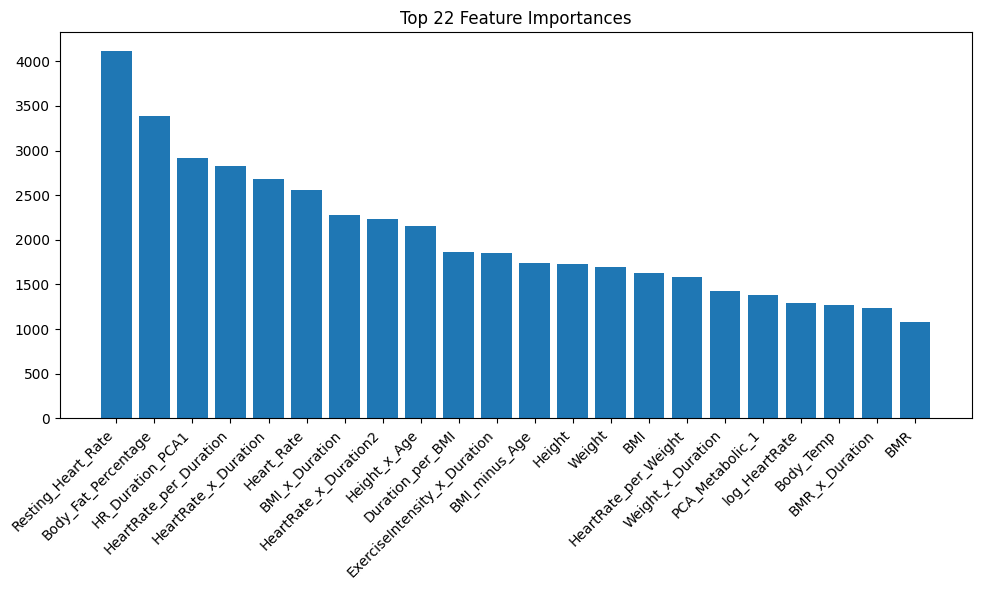

In [20]:
# Plot feature importances
import matplotlib.pyplot as plt

# Get feature names and importances
feature_names = X_train.columns
importances = lgbm2_model.models[0].feature_importances_

n_cols = 22

# Sort features by importance and take top 20
indices = np.argsort(importances)[::-1][:n_cols]

# Plot
plt.figure(figsize=(10,6))
plt.title(f'Top {n_cols} Feature Importances')
plt.bar(range(n_cols), importances[indices])
plt.xticks(range(n_cols), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [16]:
[feature_names[i] for i in np.argsort(importances)[::-1]]

['Resting_Heart_Rate',
 'Body_Fat_Percentage',
 'HeartRate_x_Duration',
 'HR_Duration_PCA1',
 'HeartRate_per_Duration',
 'Heart_Rate',
 'HeartRate_x_Duration2',
 'Height_x_Age',
 'Weight',
 'Height',
 'Weight_x_Duration',
 'ExerciseIntensity_x_Duration',
 'Duration_per_BMI',
 'HeartRate_per_Weight',
 'BMI_x_Duration',
 'BMI_minus_Age',
 'BMI',
 'log_HeartRate',
 'BMR_x_Duration',
 'BMR',
 'Body_Temp',
 'Sex',
 'ExerciseIntensity_per_BMI',
 'Age',
 'BMR_per_BMI',
 'Age_minus_HeartRate',
 'RestingHR_minus_Age',
 'Duration',
 'Exercise_Intensity',
 'log_BMR',
 'sqrt_BMI',
 'HeartRate_squared',
 'log_Duration',
 'Duration_squared']

In [32]:
# Save the 'id' column before dropping it
test_ids = df_test['id']

# Drop 'id' column before prediction
df_test = df_test.drop('id', axis=1)

# Make predictions on test data
test_preds = lgbm2_model.predict(df_test)

# Create submission file
submission = pd.DataFrame({
    'id': test_ids,
    'Calories': test_preds
})

# Save submission file
submission.to_csv('data/ensemble/lgbm1_submission.csv', index=False)